In [1]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 1. Display Settings

In [2]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output="pandas")
warnings.filterwarnings("ignore")

## 2. Read the data

In [3]:
train = pd.read_csv(r"C:\Users\yashg\OneDrive\Desktop\flight-sagemaker\data\train.csv")
train.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Duration_in_minute,Price
0,IndiGo,2019-06-24,Delhi,Cochin,05:05:00,16:10:00,1,665,6442
1,Vistara,2019-06-06,Chennai,Kolkata,07:05:00,09:20:00,0,135,3687
2,Air India,2019-05-06,Kolkata,Banglore,12:00:00,07:55:00,2,1195,10151
3,Air India,2019-06-24,Delhi,Cochin,17:15:00,19:15:00,2,1560,11989
4,IndiGo,2019-04-24,Kolkata,Banglore,11:30:00,14:05:00,0,155,4804


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Airline             5760 non-null   object
 1   Date_of_Journey     5760 non-null   object
 2   Source              5760 non-null   object
 3   Destination         5760 non-null   object
 4   Dep_Time            5760 non-null   object
 5   Arrival_Time        5760 non-null   object
 6   Total_Stops         5760 non-null   int64 
 7   Duration_in_minute  5760 non-null   int64 
 8   Price               5760 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 405.1+ KB


In [6]:
X_train = train.drop(columns="Price")
y_train = train.Price.copy()

## 4.2 Airline

In [7]:
X_train.Airline

0            IndiGo
1           Vistara
2         Air India
3         Air India
4            IndiGo
           ...     
5755         IndiGo
5756    Jet Airways
5757    Jet Airways
5758        Vistara
5759    Jet Airways
Name: Airline, Length: 5760, dtype: object

In [39]:
air_transformer = Pipeline(steps = [
                                    ("imputer", SimpleImputer(strategy="most_frequent")),
                                    ("grouper", RareLabelEncoder(tol=  0.1, replace_with = "Other", n_categories=2)),
                                    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
    
])

In [40]:
air_transformer.fit_transform(X_train.loc[:, ["Airline"]])

,Airline_Air India,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
5755,0.0,1.0,0.0,0.0,0.0
5756,0.0,0.0,1.0,0.0,0.0
5757,0.0,0.0,1.0,0.0,0.0
5758,0.0,0.0,0.0,0.0,1.0


In [61]:
air_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('grouper',
                 RareLabelEncoder(n_categories=2, replace_with='Other',
                                  tol=0.1)),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

## 4.3 Date_of_Journey

In [17]:
X_train.Date_of_Journey

0       2019-06-24
1       2019-06-06
2       2019-05-06
3       2019-06-24
4       2019-04-24
           ...    
5755    2019-06-03
5756    2019-05-24
5757    2019-06-09
5758    2019-06-27
5759    2019-05-21
Name: Date_of_Journey, Length: 5760, dtype: object

In [20]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["Date_of_Journey"]])

,Date_of_Journey_month,Date_of_Journey_week,Date_of_Journey_day_of_week,Date_of_Journey_day_of_year
0,1.000000,1.000000,0.000000,0.974576
1,1.000000,0.823529,0.500000,0.822034
2,0.666667,0.588235,0.000000,0.559322
3,1.000000,1.000000,0.000000,0.974576
4,0.333333,0.470588,0.333333,0.457627
...,...,...,...,...
5755,1.000000,0.823529,0.000000,0.796610
5756,0.666667,0.705882,0.666667,0.711864
5757,1.000000,0.823529,1.000000,0.847458
5758,1.000000,1.000000,0.500000,1.000000


In [60]:
doj_transformer

Pipeline(steps=[('dt',
                 DatetimeFeatures(features_to_extract=['month', 'week',
                                                       'day_of_week',
                                                       'day_of_year'],
                                  format='mixed', yearfirst=True)),
                ('scaler', MinMaxScaler())])

### 4.3 source & destination

In [21]:
X_train.Source

0         Delhi
1       Chennai
2       Kolkata
3         Delhi
4       Kolkata
         ...   
5755     Mumbai
5756    Kolkata
5757      Delhi
5758      Delhi
5759    Kolkata
Name: Source, Length: 5760, dtype: object

In [22]:
X_train.Destination

0          Cochin
1         Kolkata
2        Banglore
3          Cochin
4        Banglore
          ...    
5755    Hyderabad
5756     Banglore
5757       Cochin
5758       Cochin
5759     Banglore
Name: Destination, Length: 5760, dtype: object

In [24]:
location_subset = X_train.loc[:, ["Source", "Destination"]]
location_subset

,Source,Destination
0,Delhi,Cochin
1,Chennai,Kolkata
2,Kolkata,Banglore
3,Delhi,Cochin
4,Kolkata,Banglore
...,...,...
5755,Mumbai,Hyderabad
5756,Kolkata,Banglore
5757,Delhi,Cochin
5758,Delhi,Cochin


In [26]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,Source,Destination
0,1.043312,1.043312
1,-1.877692,-1.877692
2,-0.200551,-0.200551
3,1.043312,1.043312
4,-0.200551,-0.200551
...,...,...
5755,-1.877692,-1.877692
5756,-0.200551,-0.200551
5757,1.043312,1.043312
5758,1.043312,1.043312


In [28]:
np.union1d(
	X_train.Source.unique(),
	X_train.Destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai'], dtype=object)

In [29]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,Source_is_north,Destination_is_north
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
5755,1,0
5756,1,0
5757,1,0
5758,1,0


In [30]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,Source,Destination,Source_is_north,Destination_is_north
0,1.043312,1.043312,1,0
1,-1.877692,-1.877692,0,1
2,-0.200551,-0.200551,1,0
3,1.043312,1.043312,1,0
4,-0.200551,-0.200551,1,0
...,...,...,...,...
5755,-1.877692,-1.877692,1,0
5756,-0.200551,-0.200551,1,0
5757,1.043312,1.043312,1,0
5758,1.043312,1.043312,1,0


In [59]:
location_transformer

FeatureUnion(transformer_list=[('part1',
                                Pipeline(steps=[('grouper',
                                                 RareLabelEncoder(n_categories=2,
                                                                  replace_with='Other',
                                                                  tol=0.1)),
                                                ('encoder', MeanEncoder()),
                                                ('scaler',
                                                 PowerTransformer())])),
                               ('part2',
                                FunctionTransformer(func=<function is_north at 0x00000241A9854EA0>))])

### 4.4 dep_time & arrival_time

In [32]:
X_train.Dep_Time

0       05:05:00
1       07:05:00
2       12:00:00
3       17:15:00
4       11:30:00
          ...   
5755    21:20:00
5756    06:30:00
5757    19:15:00
5758    14:40:00
5759    14:05:00
Name: Dep_Time, Length: 5760, dtype: object

In [55]:
X_train.Arrival_Time

0       16:10:00
1       09:20:00
2       07:55:00
3       19:15:00
4       14:05:00
          ...   
5755    22:50:00
5756    16:20:00
5757    19:00:00
5758    17:50:00
5759    04:40:00
Name: Arrival_Time, Length: 5760, dtype: object

In [56]:
time_subset = X_train.loc[:, ["Dep_Time", "Arrival_Time"]]
time_subset

,Dep_Time,Arrival_Time
0,05:05:00,16:10:00
1,07:05:00,09:20:00
2,12:00:00,07:55:00
3,17:15:00,19:15:00
4,11:30:00,14:05:00
...,...,...
5755,21:20:00,22:50:00
5756,06:30:00,16:20:00
5757,19:15:00,19:00:00
5758,14:40:00,17:50:00


In [57]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,0.217391,0.090909,0.695652,0.181818
1,0.304348,0.090909,0.391304,0.363636
2,0.521739,0.000000,0.304348,1.000000
3,0.739130,0.272727,0.826087,0.272727
4,0.478261,0.545455,0.608696,0.090909
...,...,...,...,...
5755,0.913043,0.363636,0.956522,0.909091
5756,0.260870,0.545455,0.695652,0.363636
5757,0.826087,0.272727,0.826087,0.000000
5758,0.608696,0.727273,0.739130,0.909091


In [62]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,Dep_Time_part_of_day,Arrival_Time_part_of_day
0,morning,evening
1,morning,morning
2,afternoon,morning
3,evening,evening
4,morning,afternoon
...,...,...
5755,night,night
5756,morning,evening
5757,evening,evening
5758,afternoon,evening


In [69]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,Dep_Time_part_of_day,Arrival_Time_part_of_day
0,1.000000,0.679096
1,1.000000,0.919774
2,0.000000,0.919774
3,0.183967,0.679096
4,1.000000,0.000000
...,...,...
5755,0.141829,1.000000
5756,1.000000,0.679096
5757,0.183967,0.679096
5758,0.000000,0.679096


In [70]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Dep_Time_part_of_day,Arrival_Time_part_of_day
0,0.217391,0.090909,0.695652,0.181818,1.000000,0.679096
1,0.304348,0.090909,0.391304,0.363636,1.000000,0.919774
2,0.521739,0.000000,0.304348,1.000000,0.000000,0.919774
3,0.739130,0.272727,0.826087,0.272727,0.183967,0.679096
4,0.478261,0.545455,0.608696,0.090909,1.000000,0.000000
...,...,...,...,...,...,...
5755,0.913043,0.363636,0.956522,0.909091,0.141829,1.000000
5756,0.260870,0.545455,0.695652,0.363636,1.000000,0.679096
5757,0.826087,0.272727,0.826087,0.000000,0.183967,0.679096
5758,0.608696,0.727273,0.739130,0.909091,0.000000,0.679096


In [95]:
time_transformer

FeatureUnion(transformer_list=[('part1',
                                Pipeline(steps=[('dt',
                                                 DatetimeFeatures(features_to_extract=['hour',
                                                                                       'minute'])),
                                                ('scaler', MinMaxScaler())])),
                               ('part2',
                                Pipeline(steps=[('part',
                                                 FunctionTransformer(func=<function part_of_day at 0x00000241A9854040>)),
                                                ('encoder',
                                                 CountFrequencyEncoder()),
                                                ('scaler', MinMaxScaler())]))])

## 4.5 duration

In [71]:
X_train.Duration_in_minute

0        665
1        135
2       1195
3       1560
4        155
        ... 
5755      90
5756     590
5757    1425
5758     190
5759     875
Name: Duration_in_minute, Length: 5760, dtype: int64

In [75]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.Duration_in_minute.lt(short),
									    X.Duration_in_minute.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="Duration_in_minute")
	)

In [76]:
duration_category(X_train, short=180, med=400)

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,duration_cat
0,IndiGo,2019-06-24,Delhi,Cochin,05:05:00,16:10:00,1,long
1,Vistara,2019-06-06,Chennai,Kolkata,07:05:00,09:20:00,0,short
2,Air India,2019-05-06,Kolkata,Banglore,12:00:00,07:55:00,2,long
3,Air India,2019-06-24,Delhi,Cochin,17:15:00,19:15:00,2,long
4,IndiGo,2019-04-24,Kolkata,Banglore,11:30:00,14:05:00,0,short
...,...,...,...,...,...,...,...,...
5755,IndiGo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,0,short
5756,Jet Airways,2019-05-24,Kolkata,Banglore,06:30:00,16:20:00,1,long
5757,Jet Airways,2019-06-09,Delhi,Cochin,19:15:00,19:00:00,1,long
5758,Vistara,2019-06-27,Delhi,Cochin,14:40:00,17:50:00,0,medium


In [77]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.Duration_in_minute.ge(value).astype(int)
		})
		.drop(columns="Duration_in_minute")
	)

In [78]:
is_over(X_train)

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,duration_over_1000
0,IndiGo,2019-06-24,Delhi,Cochin,05:05:00,16:10:00,1,0
1,Vistara,2019-06-06,Chennai,Kolkata,07:05:00,09:20:00,0,0
2,Air India,2019-05-06,Kolkata,Banglore,12:00:00,07:55:00,2,1
3,Air India,2019-06-24,Delhi,Cochin,17:15:00,19:15:00,2,1
4,IndiGo,2019-04-24,Kolkata,Banglore,11:30:00,14:05:00,0,0
...,...,...,...,...,...,...,...,...
5755,IndiGo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,0,0
5756,Jet Airways,2019-05-24,Kolkata,Banglore,06:30:00,16:20:00,1,0
5757,Jet Airways,2019-06-09,Delhi,Cochin,19:15:00,19:00:00,1,1
5758,Vistara,2019-06-27,Delhi,Cochin,14:40:00,17:50:00,0,0


In [80]:
duration_pipe = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe),
	("part2", FunctionTransformer(func=is_over)),
	("part3", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["Duration_in_minute"]])

,duration_cat,duration_over_1000,Duration_in_minute
0,2.0,0,0.077672
1,0.0,0,-0.991507
2,2.0,1,1.146852
3,2.0,1,1.883173
4,0.0,0,-0.951161
...,...,...,...
5755,0.0,0,-1.082287
5756,2.0,0,-0.073627
5757,2.0,1,1.610835
5758,1.0,0,-0.880555


In [81]:
duration_transformer

Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('imputer', SimpleImputer(strategy='median')),
                ('union',
                 FeatureUnion(transformer_list=[('part1',
                                                 Pipeline(steps=[('cat',
                                                                  FunctionTransformer(func=<function duration_category at 0x00000241A9300540>)),
                                                                 ('encoder',
                                                                  OrdinalEncoder(categories=[['short',
                                                                                              'medium',
                                                                                              'long']]))])),
                                                ('part2',
                                                 FunctionTransformer(func=<function is_over at 0x00000241A93559E0>)),
                                                ('part3', StandardScaler())]))])

### 4.6 total_stops

In [84]:
X_train.Total_Stops

0       1
1       0
2       2
3       2
4       0
       ..
5755    0
5756    1
5757    1
5758    0
5759    1
Name: Total_Stops, Length: 5760, dtype: int64

In [86]:
def is_direct(X):
	return X.assign(is_direct_flight=X.Total_Stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["Total_Stops"]])

,Total_Stops,is_direct_flight
0,1,0
1,0,1
2,2,0
3,2,0
4,0,1
...,...,...
5755,0,1
5756,1,0
5757,1,0
5758,0,1


In [87]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["Airline"]),
	("doj", doj_transformer, ["Date_of_Journey"]),
	("location", location_transformer, ["Source", 'Destination']),
    ("time", time_transformer, ["Dep_Time", "Arrival_Time"]),
	("dur", duration_transformer, ["Duration_in_minute"]),
    ("stops", total_stops_transformer, ["Total_Stops"]),],remainder="passthrough" ) 

column_transformer.fit_transform(X_train, y_train)

,air__Airline_Air India,air__Airline_IndiGo,air__Airline_Jet Airways,air__Airline_Multiple carriers,air__Airline_Other,doj__Date_of_Journey_month,doj__Date_of_Journey_week,doj__Date_of_Journey_day_of_week,doj__Date_of_Journey_day_of_year,location__Source,location__Destination,location__Source_is_north,location__Destination_is_north,time__Dep_Time_hour,time__Dep_Time_minute,time__Arrival_Time_hour,time__Arrival_Time_minute,time__Dep_Time_part_of_day,time__Arrival_Time_part_of_day,dur__duration_cat,dur__duration_over_1000,dur__Duration_in_minute,stops__Total_Stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.974576,1.043312,1.043312,1,0,0.217391,0.090909,0.695652,0.181818,1.000000,0.679096,2.0,0,0.077672,1,0
1,0.0,0.0,0.0,0.0,1.0,1.000000,0.823529,0.500000,0.822034,-1.877692,-1.877692,0,1,0.304348,0.090909,0.391304,0.363636,1.000000,0.919774,0.0,0,-0.991507,0,1
2,1.0,0.0,0.0,0.0,0.0,0.666667,0.588235,0.000000,0.559322,-0.200551,-0.200551,1,0,0.521739,0.000000,0.304348,1.000000,0.000000,0.919774,2.0,1,1.146852,2,0
3,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.974576,1.043312,1.043312,1,0,0.739130,0.272727,0.826087,0.272727,0.183967,0.679096,2.0,1,1.883173,2,0
4,0.0,1.0,0.0,0.0,0.0,0.333333,0.470588,0.333333,0.457627,-0.200551,-0.200551,1,0,0.478261,0.545455,0.608696,0.090909,1.000000,0.000000,0.0,0,-0.951161,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,-1.877692,-1.877692,1,0,0.913043,0.363636,0.956522,0.909091,0.141829,1.000000,0.0,0,-1.082287,0,1
5756,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.666667,0.711864,-0.200551,-0.200551,1,0,0.260870,0.545455,0.695652,0.363636,1.000000,0.679096,2.0,0,-0.073627,1,0
5757,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,1.000000,0.847458,1.043312,1.043312,1,0,0.826087,0.272727,0.826087,0.000000,0.183967,0.679096,2.0,1,1.610835,1,0
5758,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.500000,1.000000,1.043312,1.043312,1,0,0.608696,0.727273,0.739130,0.909091,0.000000,0.679096,1.0,0,-0.880555,0,1


In [88]:
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('air',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('grouper',
                                                  RareLabelEncoder(n_categories=2,
                                                                   replace_with='Other',
                                                                   tol=0.1)),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Airline']),
                                ('doj',
                                 Pipeline(steps=[('dt',
                                                  DatetimeFeatures(features_to_e...
                                                                                                   OrdinalEncoder(categories=[['short',
                                                                                                                               'medium',
                                                                                                                               'long']]))])),
                                                                                 ('part2',
                                                                                  FunctionTransformer(func=<function is_over at 0x00000241A93559E0>)),
                                                                                 ('part3',
                                                                                  StandardScaler())]))]),
                                 ['Duration_in_minute']),
                                ('stops',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('',
                                                  FunctionTransformer(func=<function is_direct at 0x00000241A93014E0>))]),
                                 ['Total_Stops'])])

### 5. Feature Selection

In [90]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

### 6. Putting it all Together

In [91]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__Airline_IndiGo,air__Airline_Jet Airways,air__Airline_Other,doj__Date_of_Journey_week,doj__Date_of_Journey_day_of_year,location__Source,location__Destination,dur__duration_cat,dur__duration_over_1000,dur__Duration_in_minute,stops__Total_Stops,stops__is_direct_flight
0,1.0,0.0,0.0,1.000000,0.974576,1.043312,1.043312,2.0,0,0.077672,1,0
1,0.0,0.0,1.0,0.823529,0.822034,-1.877692,-1.877692,0.0,0,-0.991507,0,1
2,0.0,0.0,0.0,0.588235,0.559322,-0.200551,-0.200551,2.0,1,1.146852,2,0
3,0.0,0.0,0.0,1.000000,0.974576,1.043312,1.043312,2.0,1,1.883173,2,0
4,1.0,0.0,0.0,0.470588,0.457627,-0.200551,-0.200551,0.0,0,-0.951161,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5755,1.0,0.0,0.0,0.823529,0.796610,-1.877692,-1.877692,0.0,0,-1.082287,0,1
5756,0.0,1.0,0.0,0.705882,0.711864,-0.200551,-0.200551,2.0,0,-0.073627,1,0
5757,0.0,1.0,0.0,0.823529,0.847458,1.043312,1.043312,2.0,1,1.610835,1,0
5758,0.0,0.0,1.0,1.000000,1.000000,1.043312,1.043312,1.0,0,-0.880555,0,1


### Visualization

In [92]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__Airline_Air India': 0.0010951043761450545,
 'air__Airline_IndiGo': 0.13568339927912468,
 'air__Airline_Jet Airways': 0.18336201770537394,
 'air__Airline_Multiple carriers': 0.02248306724154155,
 'air__Airline_Other': 0.11762904797042517,
 'doj__Date_of_Journey_month': 0.08281383082194989,
 'doj__Date_of_Journey_week': 0.17083549385399388,
 'doj__Date_of_Journey_day_of_week': 0.0036547294553960588,
 'doj__Date_of_Journey_day_of_year': 0.2120910457746873,
 'location__Source': 0.14761150955338262,
 'location__Destination': 0.14761150955338262,
 'location__Source_is_north': 0.03982240874316038,
 'location__Destination_is_north': 0.03982240874316038,
 'time__Dep_Time_hour': 0.009857796140444944,
 'time__Dep_Time_minute': 0.03657724709961981,
 'time__Arrival_Time_hour': 0.07882188407761126,
 'time__Arrival_Time_minute': 0.035647050689616266,
 'time__Dep_Time_part_of_day': -0.0021658717823795914,
 'time__Arrival_Time_part_of_day': 0.02606039433062013,
 'dur__duration_cat': 0.4098106260

In [93]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__Dep_Time_part_of_day': -0.0021658717823795914,
 'air__Airline_Air India': 0.0010951043761450545,
 'doj__Date_of_Journey_day_of_week': 0.0036547294553960588,
 'time__Dep_Time_hour': 0.009857796140444944,
 'air__Airline_Multiple carriers': 0.02248306724154155,
 'time__Arrival_Time_part_of_day': 0.02606039433062013,
 'time__Arrival_Time_minute': 0.035647050689616266,
 'time__Dep_Time_minute': 0.03657724709961981,
 'location__Source_is_north': 0.03982240874316038,
 'location__Destination_is_north': 0.03982240874316038,
 'time__Arrival_Time_hour': 0.07882188407761126,
 'doj__Date_of_Journey_month': 0.08281383082194989,
 'dur__duration_over_1000': 0.11168301651944068,
 'air__Airline_Other': 0.11762904797042517,
 'air__Airline_IndiGo': 0.13568339927912468,
 'location__Source': 0.14761150955338262,
 'location__Destination': 0.14761150955338262,
 'doj__Date_of_Journey_week': 0.17083549385399388,
 'air__Airline_Jet Airways': 0.18336201770537394,
 'doj__Date_of_Journey_day_of_year': 0.212

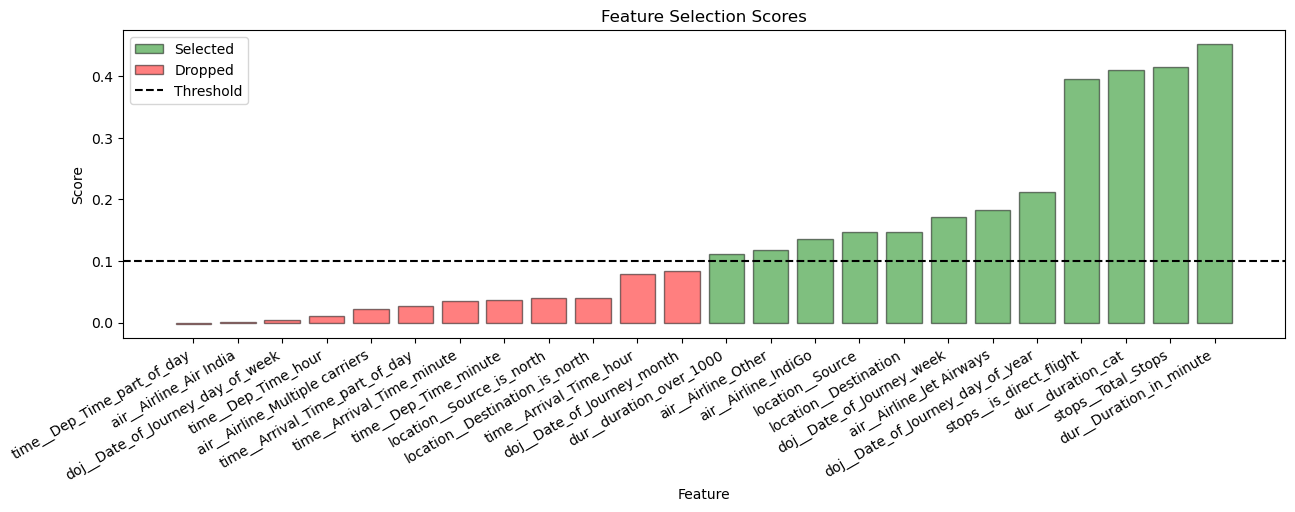

In [94]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()